In [1]:
!pip install imblearn
!pip install seaborn

  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached scipy-1.11.4-cp311-cp311-macosx_12_0_arm64.whl.metadata (165 kB)
  Using cached scikit_learn-1.3.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-macosx_12_0_arm64.whl (9.4 MB)
Using cached scipy-1.11.4-cp311-cp311-macosx_12_0_arm64.whl (29.7 MB)
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached matplotlib-3.8.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Load dataset
input_file_path = '../data/feature_extraction/BERT_Features.csv'
df = pd.read_csv(input_file_path)

# Select your features and target
X = df.iloc[:, 7:].values  # Assuming BERT features start from the 8th column
y = df['Sentiment']  # Assuming 'Sentiment' is your label column

# Encoding categorical labels
y_encoded = pd.get_dummies(y).values

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Reshape X to have 3 dimensions [samples, timesteps, features]
# Assuming each sample is a single timestep
# Reshape X to have 3 dimensions [samples, timesteps, features]
# Assuming each sample is a single timestep
X_train_smote = np.expand_dims(X_train_smote, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Define your LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_smote.shape[1], X_train_smote.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train_smote.shape[1], activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_smote, y_train_smote, epochs=20, batch_size=32, validation_split=0.3)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
172/172 [==============================] - 2s 4ms/step - loss: 0.8895 - accuracy: 0.5930 - val_loss: 0.9181 - val_accuracy: 0.6060
Epoch 2/20
172/172 [==============================] - 0s 2ms/step - loss: 0.6989 - accuracy: 0.7081 - val_loss: 0.5799 - val_accuracy: 0.7824
Epoch 3/20
172/172 [==============================] - 0s 2ms/step - loss: 0.5607 - accuracy: 0.7670 - val_loss: 0.3001 - val_accuracy: 0.9040
Epoch 4/20
172/172 [==============================] - 0s 2ms/step - loss: 0.4781 - accuracy: 0.7952 - val_loss: 0.4517 - val_accuracy: 0.8156
Epoch 5/20
172/172 [==============================] - 0s 2ms/step - loss: 0.4092 - accuracy: 0.8320 - val_loss: 0.2687 - val_accuracy: 0.8950
Epoch 6/20
172/172 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8371 - val_loss: 0.1551 - val_accuracy: 0.9418
Epoch 7/20
172/172 [==============================] - 0s 2ms/step - loss: 0.3368 - accuracy: 0.8614 - val_loss: 0.1421 - val_accuracy: 0.9456
Epoch 

In [8]:
import pickle
pickle.dump(model, open('../model/lstm_model.pkl', 'wb'))

36/36 [==============================] - 0s 809us/step


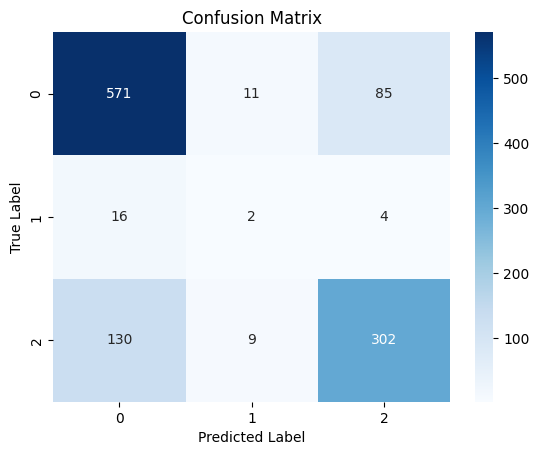

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       667
           1       0.09      0.09      0.09        22
           2       0.77      0.68      0.73       441

    accuracy                           0.77      1130
   macro avg       0.55      0.54      0.55      1130
weighted avg       0.77      0.77      0.77      1130



In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Printing classification report
print(classification_report(y_true, y_pred_classes))
